## Let's start by adding some useful imports
Note: utils is a custom python module that I created for some simple operations.
Check utils/common_utils.py for more details

In [3]:
import os
import uuid
import yaml

from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.common_utils import cleanup, create_gif_from_images, generateSamples, restore_checkpoint_status, save_images, save_model_state


# set the tensorflow verbosity
tf.logging.set_verbosity(tf.logging.INFO)

## Download the MNIST dataset using the in-built tensorflow modules

In [4]:
# get the mnist dataset from tensorflow
mnist = tf.contrib.learn.datasets.load_dataset('mnist')
training_data = mnist.train.images
testing_data = mnist.test.images
validation_data = mnist.validation.images

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### The code below uses the notion of experiments which basically signifies a new experiment run on the network with different Neural Network hyperparameters. 

### Make sure to change this experiment-id when running the network using a new set of hyperparameters

In [ ]:
NUM_DIMS = 28
NUM_SAMPLES = training_data.shape[0]
FLATTENED_DIMS = 784

"""
Defines the experiment id for a experiment.
Make sure to update the experiment id when running the code using a new set of hyperparameters
"""
experiment_id = '2'
# specify the directory where to save the samples generated by the generator
SRC_DIR = './model_data_dcgan/experiment_{}'.format(experiment_id)

### Display some images from the dataset to check if we have loaded the dataset correctly

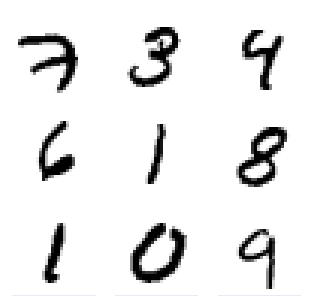

In [6]:
save_images(training_data[0:9,:], show=True, dpi=125)

### Define the hyperparameters for the Generator and the Discriminator here as a python dictionary. This object is then written to the config.yaml file after the training ends

In [7]:
"""
learning_rate : learning_rate used during the training procedure
k : The number of steps used to train the discriminator
noise_dim : The number of dimensions of the noise input to the generator net
dropout_rate : The rate of dropout used in the dicriminator network
num_steps: The number of steps to train the nets for
m : The number of samples used for training the nets (half of the batch size)
noise_variance : The variance of noise for sampling noise samples
"""
# define the learning hyperparameters as a dictionary
config = {
    "starting_learning_rate":0.0002,
    "k":1,
    "noise_dim":100,
    "dropout_rate":0.5,
    "decay_steps":10000,
    "decay_rate":0.96,
    "num_steps":5000,
    "m":128,
    "noise_variance":0.02,
    "beta1":0.5,

    # define the network hyperparameter
    "gen_layers_units":{
        "projection_dim" : 16,
        "deconv_1" : 1024,
        "deconv_2" : 512,
        "deconv_3" : 256
    },
    "dis_layers_units":{
        "conv_1" : 256,
        "conv_2" : 512,
        "conv_3" : 1024
    },
}

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(config['starting_learning_rate'], 
                                           global_step, 
                                           config['decay_steps'], 
                                           config['decay_rate'], 
                                           staircase=True)

### Define the Input placeholders to the network

In [8]:
# define the input placeholders
X = tf.placeholder(dtype=tf.float32, shape=(None, NUM_DIMS, NUM_DIMS, 1), name='Training-input')
Z = tf.placeholder(dtype=tf.float32, shape=(None, config['noise_dim']), name='Noise-input')
batch_norm = tf.placeholder(dtype=tf.bool, name='Generator-batchnorm')

# this noise sample is used to visualize the generator learning over time
base_noise_sample = tf.Variable(np.random.normal(size=(9, config['noise_dim']), 
                                                 scale=config['noise_variance']), 
                                dtype=tf.float32, 
                                expected_shape=(9, config['noise_dim']))

### Define the Generator network. We use the TF Layers Api to create our network. Refer to the Tensorflow documentation on the Layers API for more details. Feel Free to play around with the generator architecture.

In [9]:
def generator(noise_samples):
    
    with tf.variable_scope('GEN', reuse=tf.AUTO_REUSE):
        
        # project the noise to a vector
        projected_samples = tf.layers.dense(noise_samples, 16, activation=tf.nn.relu)
        
        # reshape the projected samples to a 4D tensor
        noise_input = tf.reshape(projected_samples, [-1, 4, 4, 1])
        
        # define the generator network
        ####  First conv layer ####
        outputg_conv_1 = tf.layers.conv2d_transpose(noise_input, filters=config['gen_layers_units']['deconv_1'], kernel_size=(4, 4), activation=tf.nn.relu)
        outputg_batchnorm_1 = tf.layers.batch_normalization(outputg_conv_1, scale=False, training=batch_norm)
        
        ####  Second conv layer ####
        outputg_conv_2 = tf.layers.conv2d_transpose(outputg_batchnorm_1, filters=config['gen_layers_units']['deconv_2'], kernel_size=(4, 4), activation=tf.nn.relu)
#         outputg_batchnorm_2 = tf.layers.batch_normalization(outputg_conv_2, scale=False, training=batch_norm)
        
        ####  Third conv layer ####
        outputg_conv_3 = tf.layers.conv2d_transpose(outputg_conv_2, filters=config['gen_layers_units']['deconv_3'], kernel_size=(4, 4), activation=tf.nn.relu)
        
        # the output of the generator network
        outputg = tf.layers.conv2d_transpose(outputg_conv_3, filters=1, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.tanh)
    
    return outputg

### Define the Discriminator network

In [10]:
def discriminator(x):
    
    with tf.variable_scope('DIS', reuse=tf.AUTO_REUSE):
        
        # define the discriminator network
        
        ####  First conv layer ####
        outputd_conv_1 = tf.layers.conv2d(x, filters=config['dis_layers_units']['conv_1'], kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.leaky_relu)
        outputd_dropout_1 = tf.layers.dropout(outputd_conv_1, rate=config['dropout_rate'], training=True)
        
        ####  Second conv layer ####
        outputd_conv_2 = tf.layers.conv2d(outputd_dropout_1, filters=config['dis_layers_units']['conv_2'], kernel_size=(4, 4), activation=tf.nn.leaky_relu)
        
        ####  Third conv layer ####
        outputd_conv_3 = tf.layers.conv2d(outputd_conv_2, filters=config['dis_layers_units']['conv_3'], kernel_size=(4, 4), activation=tf.nn.leaky_relu)
        outputd_flatten_3 = tf.layers.flatten(outputd_conv_3)
        
        # the output of the discriminator network (The classification probability)
        logit = tf.layers.dense(outputd_flatten_3, 1, activation=None)
        outputd = tf.nn.sigmoid(logit)
    
    return (logit, outputd)

### Define the Tensorflow ops to create the GAN, the loss metrics and the Optimizer ops to train the GAN

In [ ]:
# define the network ops
generator_output = generator(Z)
d_real_logit, d_real_output = discriminator(X)
d_fake_logit, d_fake_output = discriminator(generator_output)

# define the loss ops
D_loss = -tf.reduce_mean(tf.log(d_real_output) + tf.log(1 - d_fake_output))
G_loss = -tf.reduce_mean(tf.log(d_fake_output))

# define the optimizer ops
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GEN")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="DIS")

# define the update ops to run batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=config['beta1']).minimize(D_loss, var_list=disc_vars)
    g_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=config['beta1']).minimize(G_loss, var_list=gen_vars)

# define the session variable
saver = tf.train.Saver()
checkpoint_path = os.path.join(SRC_DIR, 'checkpoints', 'model-{}.ckpt'.format(experiment_id))
tmp_dir_path = os.path.join(SRC_DIR, 'tmp')

sess = tf.InteractiveSession()

# restore the checkpoint status for this experiment
status = restore_checkpoint_status(saver, sess, checkpoint_path)
if not status:
    sess.run(tf.global_variables_initializer())
    # remove the contents of the tmp location
    if(os.path.exists(tmp_dir_path)):
        cleanup(tmp_dir_path)
    

### Define the optimize method to train the GAN architecture using Tensorflow Sessions. Here we train the network by alternating the training between the Discriminator and the Generator i.e k steps of training D followed by a step for training G. 

### Also at every 100th training step we save an image sample generated from the Generator by giving a fixed noise vector as input. These images will be used to generate an animation over time displaying the learning of the Generator.

In [11]:
# define the optimization procedure
def optimize():
        
    for epoch_idx in range(config["num_steps"]):
        status = epoch_idx % 500
        for train_idx in range(config['k']):
      
            training_batch, _ = mnist.train.next_batch(batch_size=config['m'])
            training_batch = np.reshape(training_batch, newshape=(config['m'], NUM_DIMS, NUM_DIMS, 1))
#             optimize the discriminator network
            _, discriminator_loss = sess.run([d_optimizer, D_loss], feed_dict={Z:generateSamples(config['m'], 
                                                                                                 config['noise_dim'], 
                                                                                                 config['noise_variance']), X:training_batch, batch_norm:True})
            if(status == 0):
              print('Step {}: D-Loss:{}'.format(epoch_idx, discriminator_loss))

#         optimize the generator network
        _, generator_loss = sess.run([g_optimizer, G_loss], feed_dict={Z:generateSamples(config['m'], 
                                                                                         config['noise_dim'], 
                                                                                         config['noise_variance']), batch_norm:True})
        
        if(epoch_idx % 100 == 0):
            # run the generator on a small number of samples
            generator_sample_output = sess.run(generator_output, feed_dict={Z:sess.run(base_noise_sample), batch_norm:False})
#             save the image
            img_id = str(uuid.uuid4())
            save_images(generator_sample_output, tmp_path=tmp_dir_path, save=True, id=str(uuid.uuid4())[:5], dpi=125)
    
        if(status == 0):
            print('Step {}: G-Loss:{}'.format(epoch_idx, generator_loss))
#             checkpoint the training
            save_model_state(saver, sess, checkpoint_path)

No checkpoint found. Starting training.....


In [12]:
optimize()

Step 0: D-Loss:1.384556531906128
Step 0: G-Loss:0.6918184757232666
Step 500: D-Loss:0.4903964400291443
Step 500: G-Loss:2.412503719329834
Step 1000: D-Loss:0.5906983613967896
Step 1000: G-Loss:1.7582556009292603
Step 1500: D-Loss:0.6077720522880554
Step 1500: G-Loss:1.996638536453247
Step 2000: D-Loss:0.5905699729919434
Step 2000: G-Loss:3.6454572677612305
Step 2500: D-Loss:0.6678098440170288
Step 2500: G-Loss:2.0524895191192627
Step 3000: D-Loss:0.6706891059875488
Step 3000: G-Loss:1.5557472705841064
Step 3500: D-Loss:0.6228235363960266
Step 3500: G-Loss:1.8531230688095093
Step 4000: D-Loss:0.5795398950576782
Step 4000: G-Loss:2.716036558151245
Step 4500: D-Loss:0.6114509105682373
Step 4500: G-Loss:2.619839668273926


### Plot some test images generated by the Generator Network and create a gif animation from the images generated earlier during training. Also write the network hyperparameters to a file.

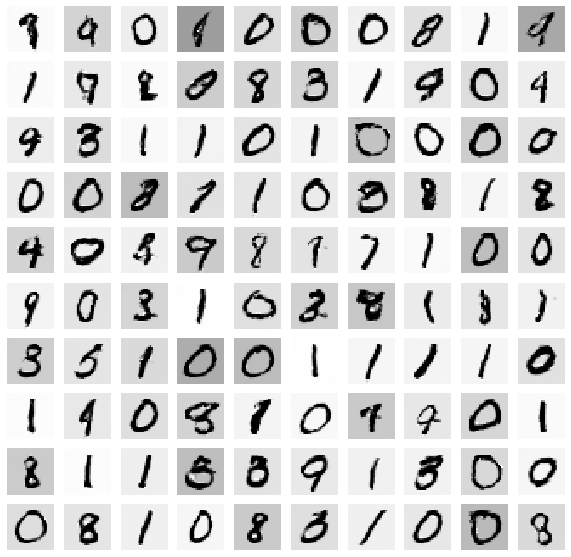

In [17]:
def plot_test_images(session, generator_op):
    
    noise_test = np.random.normal(scale=config['noise_variance'], size=(100, config['noise_dim']))
    images = sess.run(generator_op, feed_dict={Z:noise_test, batch_norm:False})
    # plot the generated test images
    save_images(images, show=True)
    
plot_test_images(sess, generator_output)

# create a gif of the images in the directory and store
src = os.path.join(SRC_DIR, 'tmp')
dst = os.path.join(SRC_DIR, 'gifs/visualization.gif')
create_gif_from_images(src, dst)

# save the network configuration to a file
config_file = os.path.join(SRC_DIR, 'config.yaml')
with open(config_file, 'w') as writer:
    yaml.dump(config, writer, default_flow_style=False)
    
# cleanup(os.path.join(SRC_DIR, 'tmp'))
# cleanup(os.path.join(SRC_DIR, 'gifs'))
# cleanup(os.path.join(SRC_DIR, 'checkpoints'))